### Motivación
Hasta el momento, los modelos y técnicas predictivas se han basado en procesos
matemáticos relativamente complejos que son entendibles para la máquina, pero no para
nosotros. Lo ideal sería encontrar un modelo que combine un buen desempeño predictivo,
junto con una interpretación más humana de los datos que incorporamos. Ya tenemos
conocimiento sobre el enfoque de la regresión para modelar problemas, haciéndola atractiva
dado su capacidad de interpretación. Ahora conoceremos los árboles de decisión, una
técnica sustancialmente más entendible para el investigador.

Los árboles de decisión se asemejan a la forma en que los seres humanos toman
decisiones. Básicamente aprenden una jerarquía de preguntas en formato if/else que
conllevan a una decisión. Para ejemplificar el caso de uso, imaginemos que nos pasan una
serie de datos sobre animales y nos piden clasificarlos acorde a si son mamíferos o no. Los
datos entregados tienen la siguiente estructura:

In [1]:
import pandas as pd
import numpy as np

#from IPython.display import display
#from PIL import Image

import pydotplus
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
#from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from IPython.display import Image
import lec7_graphs as afx

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Datasets/vertebrate.csv')

In [3]:
df.sample(5, random_state = 15820)

,name,warm_blood,gives_birth,aquatic,aerial,has_legs,hibernates,class
1,python,0,0,0,0,0,1,reptiles
5,komodo,0,0,0,0,1,0,reptiles
8,cat,1,1,0,0,1,0,mammals
10,turtle,0,0,1,0,1,0,reptiles
6,bat,1,1,0,1,1,1,mammals


Tenemos los siguientes atributos para cada animal: Si son de sangre caliente, si dan a luz, si
son acuáticos o aéreos, si tienen piernas e hibernan. El objetivo de un árbol de decisión es
identificar qué atributos facilitan la discriminación de nuestra respuesta. Sabemos de
antemano que las principales características de un mamífero son que den a luz y que tengan
sangre caliente. Lo que buscamos es realizar una pregunta a cada atributo sobre cada
observación, y posteriormente seguir realizando preguntas hasta que nuestras categorías.
Mientras que para nosotros la discriminación de atributos es intuitiva y fácil de implementar,
una máquina necesita más pasos.

Para un árbol de decisión, el proceso de discriminación de clases implica identificar qué
atributos facilitan la discriminación y qué tan pura es la discriminación en cada fase.
Tomemos como ejemplo la figura realizada con afx.demo_classsification_tree.
Partimos con una pregunta inicial que se conoce como nodo, ¿Da a luz el animal?. Con 15
observaciones observamos que hay 9 observaciones que no dan a luz y por tanto no son
mamíferos. Cuando una pregunta llega a un punto de pureza (sólo existe una clase en su
partición), no hay preguntas por realizar y el proceso para esta fase se conoce como nodo
terminal o hoja.

In [4]:
# recodificamos en mamiferos/no mamiferos
df['class'] = df['class'].replace(['fishes','birds','amphibians','reptiles'],'no-mamiferos')
# guardamos los nombres de las clases en un nuevo objeto
store_y_labels = df['class'].unique()
# recodificamos de forma binaria
df['class'] = np.where(df['class'] == 'mammals', 1, 0)
# eliminamos atributos irrelevantes de la matriz de atributos
X_mat = df.drop(columns=['name', 'class'])
# Implementamos nuestra función y la guardamos en un nuevo objeto
dec_tree = afx.demo_classfication_tree(X_mat, df['class'], store_y_labels)

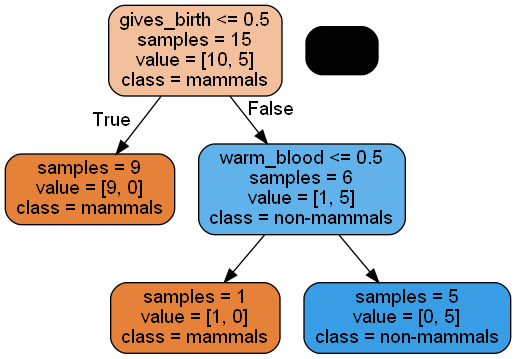

In [5]:
# renderizamos el objeto
Image(dec_tree.create_png())

In [6]:
# Crear un objeto clasificvador arbol de desicion
clf = DecisionTreeClassifier(random_state = 15820)

In [7]:
# Entrebamiento del modelo
model = clf.fit(X_mat, df['class'])

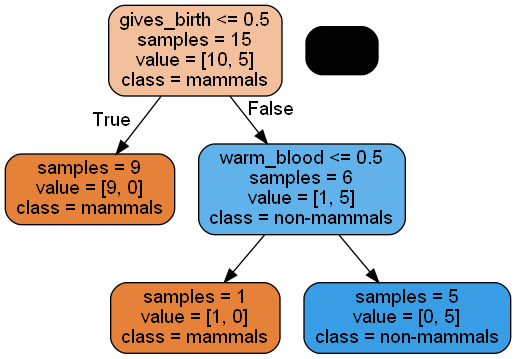

In [8]:
# Crear datos DOT
dot_data = tree.export_graphviz(clf, out_file = None, feature_names = X_mat.columns,
                                class_names = store_y_labels, filled = True, rounded = True,
                                impurity = False)

# Dibujar graficas
graph = pydotplus.graph_from_dot_data(dot_data)  

# Mostrar graficas
Image(graph.create_png())

En este caso, observamos que posterior a la pregunta sobre cómo da a luz el animal, la
siguiente pregunta es si el animal es de sangre caliente o no. El objetivo de esta pregunta es
aumentar la pureza de la partición. Es en este nodo donde logramos identificar todos los
mamíferos. Otro análogo al proceso es mediante el desarrollo de queries:

### Query 1: ¿Dá a luz?
- Separamos entre los grupos con respuesta positiva:


In [9]:
question_1_pos = df.query('gives_birth == 1')

- Y el grupo con respuesta negativa:

In [10]:
question_1_neg = df.query('gives_birth == 0')

- Investigamos la pureza de la clase. Para los animales que no dan a luz, no hay casos identificados como mamíferos. Por tanto no podemos seguir preguntando.

In [12]:
question_1_neg['class'].value_counts()

0    9
Name: class, dtype: int64

- Investigamos la pureza de la clase para los casos negativos. Para los animales que si dan a luz, hay 1 que no es mamífero. Podemos seguir analizando este subconjunto.

In [13]:
question_1_pos['class'].value_counts()

1    5
0    1
Name: class, dtype: int64

### Query 2: ¿Es de sangre caliente?
- En base al subgrupo podemos separar entre los grupos con respuesta positiva.


In [14]:
question_2_pos = question_1_pos.query('warm_blood == 1')

- El grupo con respuesta negativa.

In [15]:
question_2_neg = question_1_pos.query('warm_blood == 0')


- Investigamos la pureza de la clase. Para los animales con sangre caliente, todos los casos identificados son mamíferos y alcanzamos pureza.

In [16]:
question_2_pos['class'].value_counts()

1    5
Name: class, dtype: int64

In [17]:
question_2_neg['class'].value_counts()

0    1
Name: class, dtype: int64

Lo que realizamos arriba se conoce como un proceso de búsqueda greedy: buscamos
optimizar de forma local en base a la pregunta. Resulta que las máquinas toman en cuenta
otros atributos y procesos para realizar una partición con pureza.